<table border="0">
    <tr>
        <td>
            <img src="https://ictd2016.files.wordpress.com/2016/04/microsoft-research-logo-copy.jpg" style="width 30px;" />
             </td>
        <td>
            <img src="https://www.microsoft.com/en-us/research/wp-content/uploads/2016/12/MSR-ALICE-HeaderGraphic-1920x720_1-800x550.jpg" style="width 100px;"/></td>
        </tr>
</table>

This notebook applies EconML's `LinearDML` and `LinearDRLearner` methodologies to the data from National Supported Work (NSW) Demonstration that have been previously analyzed by LaLonde(1986) and others. We first replicate the results from LaLonde's paper comparing estimates of the Average Treatment Effect (ATE) of a worker training program estimated using an experimental data sample and using alternative observational data sets as controls. Then we generate new estimated ATEs using **Double Machine Learning** and **Doubly Robust** estimation on these same datasets. These new causal machine learning techniques have a moderately better performance than the traditional nonexperimental evalutaion strategies from the original paper in some samples. We further improve the point estimate by estimating heterogeneous treatment effects and using reweighting techniques to make the observational control sets more closely resemble the experimental control set. Finally, we prove that our package provides reasonable effect heterogeneity estimates from observational data that are comparable with what we can learn from the experiment. 

These results reinforce the value of Causal ML techniques like DML and DR Learners when attempting to estimate causal effects from non-experimental data. The reweighting techniques demonstrated here are also generally useful when trying to use treatment effects estimated from one, potentially non-representative, experimental sample to forecast average treatment effects in a new population.

### Summary 

1. [Background](#background)
2. [Data](#data)
3. [Compare EconML Solution with LaLonde OLS Results](#comparison)
4. [Further Improve EconML Result with Reweighting Trick](#improvement)
7. [Heterogeneous Treatment Effect with EconML](#hte)
8. [Conclusions](#conclusion)

# Background <a id="background"></a>
<img src="https://image.freepik.com/free-vector/factory-workers-robotic-arm-removing-packages-from-conveyor-line-engineer-using-computer-operating-process-vector-illustration-business-production-machine-technology-concepts_74855-9859.jpg" width="400" />

The National Supported Work Demonstration (NSW) was a temporary employment program designed to help a population of disadvantaged workers in the U.S. move into long-term jobs by offering job training. The training program was targeted at populations of male and female workers who met certain conditions of disadvantage (for example, were receiving federal welfare payments or had previously been incarcerated). Participation in the program was also voluntary. Participation in this program is therefore not random, and likely to correlate with other confounding worker characteristics in difficult-to-identify ways.

However, once workers opted into the program, the NSW randomly assigned them to actually receive the training or remain as a control sample to facilitate later program evaluation. This set-up creates a good environment for testing estimation techniques that are designed to capture causal effects from non-experimental data. Following LaLonde, we first estimate the effect of the training by comparing the treated and control workers within the NSW program. Because these workers were randomly assigned across groups, we're not worried about any confounders, so these estimates serve as a benchmark for the true causal effect. We then re-estimate the effects of training by comparing the trained workers in the NSW sample to workers in other U.S. datasets, the Panel Study of Income Dynamics (PSID) and the Current Population Survey (CPS). These alternative control samples should differ from the workers who were targeted for the NSW program in complex ways that mirror the usual difficulties of estimating causal effects from observational data.

In [1]:
# imports
import pandas as pd
import numpy as np
import statsmodels.api as sm

from econml.dml import LinearDML
from econml.dr import LinearDRLearner
from econml.cate_interpreter import SingleTreeCateInterpreter
from econml.dml import CausalForestDML

from sklearn.linear_model import LogisticRegressionCV, LogisticRegression,Lasso,LassoCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from econml.sklearn_extensions.model_selection import GridSearchCVList


import matplotlib.pyplot as plt
from matplotlib.transforms import ScaledTranslation

%matplotlib inline

In [2]:
# helper functions
# preprocess data
def preprocessing(df,outcome_name,column_names):
    # add indicator of zero earnings
    df["re74_dummy"]=(df["re74"]>0)*1
    df["re75_dummy"]=(df["re75"]>0)*1
    # get growth of pre training earning
    df["re_diff_pre"]=df["re75"]-df["re74"]
    # add age square
    df["age_2"]=df["age"]**2
    # select columns
    df=df[column_names+[outcome_name]]
    return df

# linear regression wrapper
def ols_reg_wrapper(reg_data, x_columns, y_column, print_summary=False):
    X = reg_data[x_columns].values
    X = pd.DataFrame(sm.add_constant(X,has_constant='add'),columns=["intercept"]+x_columns)
    Y = reg_data[y_column]
    model = sm.OLS(Y, X, hasconst=True)
    results = model.fit()
    # save results for summary table
    effect = int(round(results.params['treated']))
    se = int(round(results.bse['treated']))
    lb=int(round(results.conf_int().loc["treated"][0]))
    ub=int(round(results.conf_int().loc["treated"][1]))
    if print_summary:
        print(results.summary())
    return effect, se, lb, ub

# nuisance regression model auto tunning wrapper
def first_stage_reg(X, y, *, automl=True):
    if automl:
        model = GridSearchCVList([LassoCV(),
                                  RandomForestRegressor(n_estimators=100),
                                  lgb.LGBMRegressor()],
                                 param_grid_list=[{},
                                                  {'max_depth': [5,10,20],'min_samples_leaf': [5, 10]},
                                                  {'learning_rate': [0.02,0.05,0.08], 'max_depth': [3, 5]}],
                                 cv=3,
                                 scoring='neg_mean_squared_error')
        best_est = model.fit(X, y).best_estimator_
        if isinstance(best_est, LassoCV):
            return Lasso(alpha=best_est.alpha_)
        return best_est
    else:
        model = LassoCV(cv=5).fit(X, y)
        return Lasso(alpha=model.alpha_)

# nuisance classification model auto tunning wrapper
def first_stage_clf(X, y, *, automl=True):
    if automl:
        model = GridSearchCVList([LogisticRegressionCV(max_iter=1000),
                                  RandomForestClassifier(n_estimators=100),
                                  lgb.LGBMClassifier()],
                                 param_grid_list=[{},
                                                  {'max_depth': [5,10,20],
                                                   'min_samples_leaf': [5, 10]},
                                                  {'learning_rate':[0.01,0.05,0.1],
                                                   'max_depth': [3,5]}],
                                 cv=3,
                                 scoring='neg_log_loss')
        est = model.fit(X, y).best_estimator_
        if isinstance(est,LogisticRegressionCV):
            return LogisticRegression(C=est.C_[0])
    else:
        model = LogisticRegressionCV(cv=5, max_iter=1000).fit(X, y)
        est = LogisticRegression(C=model.C_[0])
    return est

# econml dml/dr wrapper
def econml_homo_model_wrapper(reg_data, control_names,outcome_name,model_type,*,cols_to_scale, print_summary=False):
    # get variables
    X = None # no heterogeneous treatment
    W = reg_data[control_names].values
    # scale W
    scaler = StandardScaler()
    W = np.hstack([scaler.fit_transform(W[:, :cols_to_scale]).astype(np.float32), W[:, cols_to_scale:]])
    T = reg_data["treated"]
    y = reg_data[outcome_name]

    # select the best nuisances model out of econml estimator
    model_y=first_stage_reg(W, y)
    model_t=first_stage_clf(W, T)

    if model_type=='dml':
        est = LinearDML(model_y=model_y,
                        model_t=model_t,
                        discrete_treatment=True, mc_iters=5,cv=5)
    elif model_type=='dr':
        est = LinearDRLearner(model_regression=model_y,
                              model_propensity=model_t,
                              mc_iters=5,cv=5)
    else:
        raise ValueError('invalid model type %s' % model_type)
    try:
        est.fit(y, T, X=X, W=W, inference="statsmodels")
    except np.linalg.LinAlgError:
        est.fit(y, T, X=X, W=W, inference="statsmodels")

    # Get the final coefficient and intercept summary
    if model_type=="dml":
        inf=est.intercept__inference()
    else:
        inf=est.intercept__inference(T=1)
    effect=int(round(inf.point_estimate))
    se=int(round(inf.stderr))
    lb,ub=inf.conf_int(alpha=0.05)
    if print_summary:
        if model_type=='dml':
            print(est.summary(alpha=0.05))
        else:
            print(est.summary(T=1,alpha=0.05))
    return effect, se, int(round(lb)), int(round(ub))

# summary table helper function
def get_summ_table(dfs,treat_df,*,
                   df_names,basic_ols_controls,complete_ols_controls,econml_controls,
                   outcome_name,cols_to_scale):
    summ_dic={"control_name":[],"# of obs":[],"earning_growth":[],
              "OLS":[],"OLS full controls":[],
              "DML full controls":[],"DR full controls":[]}
    summ_dic1={"control_name":[],"method":[],"point_estimate":[],"stderr":[],"lower_bound":[],"upper_bound":[]}
    for df, name in tqdm(zip(dfs, df_names)):
        summ_dic["control_name"].append(name)
        summ_dic["# of obs"].append(df.shape[0])
        summ_dic1["control_name"]+=[name]*4
        # get table 5 col 1
        growth=int(np.round((df[outcome_name]-df["re75"]).mean(),0))
        summ_dic["earning_growth"].append(growth)
        # get table 5 col 5
        summ_dic1["method"].append("OLS")
        df_all=pd.concat([treat_df,df],axis=0,ignore_index=True)
        effect,se,lb,ub=ols_reg_wrapper(df_all,basic_ols_controls,outcome_name,print_summary=False)
        summ_dic["OLS"].append([effect,se])
        summ_dic1["point_estimate"].append(effect)
        summ_dic1["stderr"].append(se)
        summ_dic1["lower_bound"].append(lb)
        summ_dic1["upper_bound"].append(ub)
        # get table 5 col 10
        summ_dic1["method"].append("OLS full controls")
        effect,se,lb,ub=ols_reg_wrapper(df_all,complete_ols_controls,outcome_name,print_summary=False)
        summ_dic["OLS full controls"].append([effect,se])
        summ_dic1["point_estimate"].append(effect)
        summ_dic1["stderr"].append(se)
        summ_dic1["lower_bound"].append(lb)
        summ_dic1["upper_bound"].append(ub)
        # dml
        summ_dic1["method"].append("DML full controls")
        effect,se,lb,ub=econml_homo_model_wrapper(df_all, econml_controls,outcome_name,"dml",
                                                  cols_to_scale=cols_to_scale, print_summary=False)
        summ_dic["DML full controls"].append([effect,se])
        summ_dic1["point_estimate"].append(effect)
        summ_dic1["stderr"].append(se)
        summ_dic1["lower_bound"].append(lb)
        summ_dic1["upper_bound"].append(ub)
        # dr
        summ_dic1["method"].append("DR full controls")
        effect,se,lb,ub=econml_homo_model_wrapper(df_all, econml_controls,outcome_name,"dr",
                                                  cols_to_scale=cols_to_scale, print_summary=False)
        summ_dic["DR full controls"].append([effect,se])
        summ_dic1["point_estimate"].append(effect)
        summ_dic1["stderr"].append(se)
        summ_dic1["lower_bound"].append(lb)
        summ_dic1["upper_bound"].append(ub)

    return summ_dic,summ_dic1

# error bar helper function
def plot_errorbar(df,df_names):
    fig, ax = plt.subplots(figsize=(10,6))
    for ind,control_name in enumerate(df_names):
        sub_df=df[df["control_name"]==control_name]
        method_name=sub_df["method"].values
        point=sub_df["point_estimate"].values
        yerr=np.zeros((2,point.shape[0]))
        yerr[0,:]=point-sub_df["lower_bound"].values
        yerr[1,:]=sub_df["upper_bound"].values-point
        trans = ax.transData + ScaledTranslation((-10+ind*5)/72, 0, fig.dpi_scale_trans)
        plt.errorbar(method_name,point,yerr,fmt="o",
                     capsize=5,elinewidth=2,label=control_name,alpha=0.7,transform=trans)
    plt.axhline(y=0, color='black', linestyle='--',alpha=0.5)
    plt.legend()
    plt.xlabel("Methodology")
    plt.ylabel("ATE with CI")
    plt.title("Error bar of each method for each dataset")
    plt.show()

# Data <a id="data"></a>
We use an experimental dataset from the NSW (which includes both a control sample of workers and treated sample). We also  consider several sets of control workers from two large cross-sectional survey sof U.S. workers, the PSID and CPS. For the PSID and CPS, we consider somewhat broader samples of workers (CPS1 and PSID1 for men, PSID1 for women) and smaller samples chosen to better match the characteristics of the NSW population (CSP3 and PSID3 for men, PSID2 for women). The data for men are provided by [Dehejia and Wahba](https://users.nber.org/~rdehejia/data/.nswdata2.html) from their 1999 follow-up to LaLonde's paper. The data for women are provided by [Calonico and Smith](https://www.journals.uchicago.edu/doi/10.1086/692397) from their 2017 follow-up paper. More details on both sources are available through the linked references. 

All data sets have the same set of variables:

Feature Name|Type|Data Type|Details 
:--- |:---|:--- |:--- 
**treated** |T| Boolean| whether this person had undergone NSW job training treatment
**age** |W/X| Integer| user's age
**educ** |W/X| Integer| years of education this person has completed
**nodegree** |W/X| Boolean| whether this person has NO high school degree
**black** |W/X| Boolean| whether this person is Black
**hisp** |W/X| Boolean| whether this person is Hispanic
**married** |W/X| Boolean| whether this person is married
**haschild**|W|Boolean|whether this person has child for female
**nchildren75**|W|Integer|number of child in 1975 for female
**afdc75**|W|Boolean|AFDC status for female in 1975
**re74** |W| Float| user's real earnings in 1974 (See Smith & Todd for a discussion)
**re75** |W| Float| user's real earnings in 1975 (before treatment)
**re78** |Y| Float| user's real earnings in 1978 (after treatment for males)
**re79** |Y| Float| user's real earnings in 1979 (after treatment for females)

Below we also show the mean and standard error of each feature from different experimental and control sets for men and women:

- Summary Statistics for Men:
    
Feature Name|exp treatment|exp control|cps1|cps3|psid1|psid3
:---         |:---         |:---       |:---|:---|:--- |:--- 
**age**      |24.62 (6.69) |24.45 (6.59) |33.23 (11.05)|28.03 (10.79)|34.85 (10.44)|38.26 (12.89)      
**educ**     |10.38 (1.82) |10.19 (1.62) |12.03 (2.87) |10.24 (2.86)|12.12 (3.08)  |10.30 (3.18)
**nodegree** |0.73 (0.44)  |0.81 (0.39)  |0.30 (0.46)  |0.60 (0.49) |0.31 (0.46)   |0.51 (0.50)
**black**    |0.80 (0.40)  |0.80 (0.40)  |0.07 (0.26)  |0.20 (0.40) |0.25 (0.43)   |0.45 (0.50)
**hisp**     |0.09 (0.29)  |0.11 (0.32)  |0.07 (0.26)  |0.14 (0.35) |0.03 (0.18)   |0.12 (0.32)
**married**  |0.17 (0.37)  |0.16 (0.36)  |0.71 (0.45)  |0.51 (0.50) |0.87 (0.34)   |0.70 (0.46)
**re74**     |3571 (5773)  |3672 (6522)  |14017 (9570) |5619 (6789) |19429 (13407) |5567 (7255)
**re75**     |3066 (4875)  |3026 (5201)  |13651 (9270) |2466 (3292) |19063 (13597) |2611 (5572)
**re78**     |5976 (6924)  |5090 (5718)  |14847 (9647) |6984 (7294) |21553 (15555) |5279 (7762)
**# of obs** |297          |425          |15992        |429         |2490          |128

- Summary Statistics for Women:

Feature Name|exp treatment|exp control|psid1|psid2
:---        |:---         |:---       |:---|:---
**age**         |33.76 (7.39) |33.74 (7.15) |37.07 (10.57)|34.54 (9.34)
**educ**        |10.29 (1.93) |10.26 (2.03) |11.30 (2.77) |10.49 (2.13)
**nodegree**    |0.70 (0.46)  |0.68 (0.47)  |0.45 (0.50)  |0.59 (0.49)
**black**       |0.84 (0.37)  |0.82 (0.39)  |0.65 (0.48)  |0.86 (0.35)
**hisp**        |0.11 (0.32)  |0.13 (0.33)  |0.02 (0.12)  |0.02 (0.15)
**married**     |0.02 (0.15)  |0.04 (0.19)  |0.02 (0.14)  |0.01 (0.10)
**haschild**    |0.97 (0.16)  |0.98 (0.14)  |0.67 (0.47)  |0.97 (0.16)
**nchildren75** |2.18 (1.29)  |2.23 (1.34)  |1.71 (1.78)  |2.97 (1.79) 
**afdc75**      |1.00 (0.00)  |1.00 (0.00)  |0.28 (0.45)  |1.00 (0.00)
**re74**        |913 (2149)   |962 (2376)   |7509 (7296)  |2726 (4414)
**re75**        |861 (2004)   |879 (2195)   |7510 (7541)  |2211 (3568)
**re79**        |4665 (5554)  |3833 (5039)  |8827 (8762)  |4623 (6921)
**# of obs**    |601          |585          |648          |182



In [3]:
# Data
## female
### read in and slice data
female_data = pd.read_csv('https://raw.githubusercontent.com/py-why/EconML/refs/heads/data/datasets/Lalonde/calonico_smith_all.csv')
female_data["haschild"]=(female_data["nchildren75"]>0)*1
female_data = female_data[pd.notnull(female_data.re75) & pd.notnull(female_data.re79)]
female_treatment = female_data[female_data.treated==1.].copy()
female_control = female_data[female_data.treated==0.].copy()
female_psid1 = female_data[female_data['psid1']==1].copy()
female_psid2 = female_data[female_data['psid2']==1].copy()
### some preprocessing
female_psid1.loc[:, 'treated'] = 0
female_psid2.loc[:, 'treated'] = 0

## male
### read in and slice data
male_data = pd.read_csv('https://raw.githubusercontent.com/py-why/EconML/refs/heads/data/datasets/Lalonde/smith_todd.csv')
male_treatment = male_data[male_data.treated==1.].copy()
male_control = male_data[male_data.treated==0.].copy()
male_cps1 = pd.read_csv('https://raw.githubusercontent.com/py-why/EconML/refs/heads/data/datasets/Lalonde/cps_controls.csv')
male_psid1 = pd.read_csv('https://raw.githubusercontent.com/py-why/EconML/refs/heads/data/datasets/Lalonde/psid_controls.csv')
male_cps3 = pd.read_csv('https://raw.githubusercontent.com/py-why/EconML/refs/heads/data/datasets/Lalonde/cps_controls3.csv')
male_psid3 = pd.read_csv('https://raw.githubusercontent.com/py-why/EconML/refs/heads/data/datasets/Lalonde/psid_controls3.csv')
### some preprocessing
for df in [male_psid1,male_psid3,male_cps1,male_cps3]:
    df.rename(columns={'treat':'treated', 'education':'educ', 'hispanic':'hisp'}, inplace=True)

In [4]:
# outcome
outcome_name_male="re78"
outcome_name_female="re79"
# ols controls
basic_ols_columns = ['treated', 'age', 'age_2', 'educ', 'nodegree', 'black', 'hisp']
complete_ols_columns_male = basic_ols_columns+["married","re75","re75_dummy","re74","re74_dummy","re_diff_pre"]
complete_ols_columns_female=basic_ols_columns+["married","re75","re75_dummy","re74","re74_dummy","re_diff_pre",
                                               "afdc75","nchildren75","haschild"]
# econml controls (exclude treatment)
econml_controls_male= ['age', 'age_2', 'educ', 're75','re74','re_diff_pre','nodegree',
                       'black', 'hisp', 'married','re75_dummy','re74_dummy']
econml_controls_female= ['age', 'age_2', 'educ','nchildren75', 're75','re74','re_diff_pre','nodegree',
                         'black', 'hisp', 'married','re75_dummy','re74_dummy','afdc75','haschild']

In [5]:
# preprocessing data
male_control, male_treatment, male_psid1, male_psid3, male_cps1, male_cps3 = [
    preprocessing(df,outcome_name_male,complete_ols_columns_male)
    for df in (male_control, male_treatment, male_psid1, male_psid3, male_cps1, male_cps3)
]
female_control, female_treatment, female_psid1, female_psid2 =[
    preprocessing(df,outcome_name_female,complete_ols_columns_female)
    for df in (female_control, female_treatment, female_psid1, female_psid2)
]

# Compare EconML Solution with LaLonde OLS Results <a id="comparison"></a>
We first repilcate key results from Table 5 (for men) and Table 4 (for women) from [Lalonde (1986)](http://public.econ.duke.edu/~hf14/teaching/povertydisc/readings/lalonde1986.pdf). These tables calculate the benchmark ATE using only the experimental sample and attempt to match that benchmark by estimating treatment effects using OLS and various alternative observational untreated samples, first with a basic set of control features and then with an expanded set. We then train both `LinearDML` and `LinearDRLearner` models on each dataset, using the expanded control set.

## Treatment Effect Comparison for Men

In [6]:
#male
control_dfs_male=[male_control,male_psid1,male_psid3,male_cps1,male_cps3]
df_names_male=["exp controls","psid1","psid3","cps1","cps3"]
summ_male,summplot_male=get_summ_table(control_dfs_male,male_treatment,df_names=df_names_male,
                         basic_ols_controls=basic_ols_columns,
                         complete_ols_controls=complete_ols_columns_male,
                         econml_controls=econml_controls_male,
                         outcome_name=outcome_name_male,cols_to_scale=6
                         )

5it [04:27, 53.44s/it]


In [7]:
summ_male_df=pd.DataFrame(summ_male)
print("Numbers under each method represent [point estimate, standard error]. ")
summ_male_df

Numbers under each method represent [point estimate, standard error]. 


,control_name,# of obs,earning_growth,OLS,OLS full controls,DML full controls,DR full controls
0,exp controls,425,2063,"[798, 472]","[817, 469]","[851, 487]","[868, 486]"
1,psid1,2490,2491,"[-8067, 990]","[-1827, 825]","[-1966, 697]","[-1576, 401]"
2,psid3,128,2669,"[-509, 967]","[-239, 1029]","[133, 976]","[92, 669]"
3,cps1,15992,1196,"[-4416, 577]","[-867, 445]","[-784, 542]","[-2540, 1022]"
4,cps3,429,4518,"[-1, 681]","[210, 683]","[480, 609]","[310, 448]"


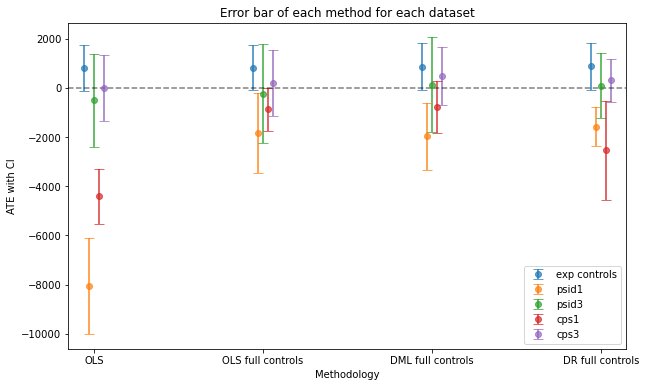

In [8]:
summplot_male_df=pd.DataFrame(summplot_male)
plot_errorbar(summplot_male_df,df_names_male)

## Treatment Effect Comparison for Women

In [9]:
# female
control_dfs_female=[female_control,female_psid1,female_psid2]
df_names_female=["exp controls","psid1","psid2"]
summ_female,summplot_female=get_summ_table(control_dfs_female,female_treatment,df_names=df_names_female,
                         basic_ols_controls=basic_ols_columns,
                         complete_ols_controls=complete_ols_columns_female,
                         econml_controls=econml_controls_female,
                         outcome_name=outcome_name_female,cols_to_scale=7
                         )

3it [01:25, 28.42s/it]


In [10]:
summ_female_df=pd.DataFrame(summ_female)
print("Numbers under each method represent [point estimate, standard error]. ")
summ_female_df

Numbers under each method represent [point estimate, standard error]. 


,control_name,# of obs,earning_growth,OLS,OLS full controls,DML full controls,DR full controls
0,exp controls,585,2954,"[858, 307]","[880, 307]","[830, 307]","[834, 307]"
1,psid1,648,1316,"[-2730, 441]","[1068, 529]","[1012, 682]","[762, 610]"
2,psid2,182,2412,"[-90, 514]","[510, 560]","[790, 711]","[777, 848]"


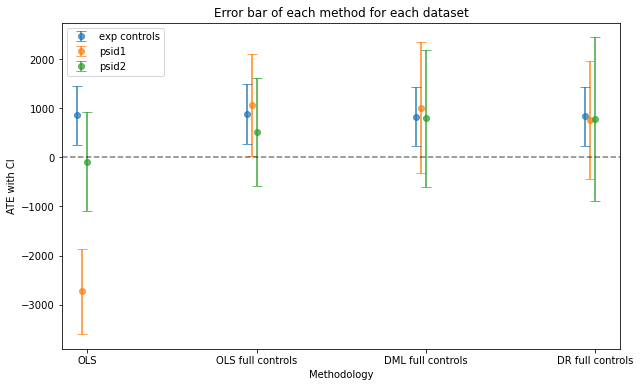

In [11]:
summplot_female_df=pd.DataFrame(summplot_female)
plot_errorbar(summplot_female_df,df_names_female)

# Improved Performance with Sample Reweighting <a id="improvement"></a>

An important difficulty in the above exercise is that all of the alternative control samples are somewhat different than the experimental NSW sample (for example, workers in the experimental sample are younger on average and far more likely to be Black or Hispanic). Even with a perfect tool for estimating causal effects from observational data, estimating the *average* treatment effect across these separate samples is unlikely to yield identical results. 

We now address this limitation by reestimating our `LinearDML` model after reweighting the observational samples to better align with the experimental sample. For this exercise we focus on the CPS3 sample for men, which was most similar to the experimental sample to begin with. We estimate a classification model between the full NSW sample and observational sample (which combines treated workers from NSW with the CPS3 control sample) to estimate the likelihood that a worker with a given set of features originated from each sample. We then reweight the CPS3 sample to give higher weight to workers who are more likely to have come from the experimental set: $$weight=P(obs\_from\_experimental\_distribution)/(1-P(obs\_from\_experimental\_distribution)) $$
Because the data samples in this exercise are so small, the estimated treatment effects from both the weighted and unweighted models are unstable. We therefore run this analysis 100 times and learn the distribution of ATE from each approach and their significance level (p value). 

In [12]:
# experimental data male
df=pd.concat([male_treatment,male_control])
# cps3 data male
df_cps=pd.concat([male_treatment,male_cps3])

In [13]:
df["label"]=1
df_cps["label"]=0
male_cls=pd.concat([df,df_cps]).reset_index(drop=True)

In [14]:
X=male_cls[econml_controls_male].values
y=male_cls["label"].values
# scale numeric features
cols_to_scale=6
scaler = StandardScaler()
X=np.hstack([scaler.fit_transform(X[:, :cols_to_scale]).astype(np.float32), X[:, cols_to_scale:]])

In [15]:
# train a classification model to learn the weight
cls=first_stage_clf(X,y)
cls.fit(X,y)
male_cls["prob"]=cls.predict_proba(X)[:,1]/cls.predict_proba(X)[:,0]
weight=male_cls[male_cls["label"]==0]["prob"].values

In [16]:
X = None
W = df_cps[econml_controls_male].values
# scale W
W = np.hstack([scaler.fit_transform(W[:, :cols_to_scale]).astype(np.float32), W[:, cols_to_scale:]])
T = df_cps["treated"]
y = df_cps[outcome_name_male]

In [17]:
model_y=first_stage_reg(W, y)
model_t=first_stage_clf(W, T)

In [18]:
# train dml with sample weight 100 times
p_value_with_weight=[]
point_estimate_with_weight=[]
for _ in range(100):
    est=LinearDML(model_t=model_t,model_y=model_y,discrete_treatment=True,mc_iters=10,cv=3)
    est.fit(y, T, X=None, W=W, sample_weight=weight,inference="statsmodels")
    point_estimate_with_weight.append(est.intercept_)
    p_value_with_weight.append(est.effect_inference().pvalue()[0])

In [19]:
# train dml without sample weight 100 times
p_value_without_weight=[]
point_estimate_without_weight=[]
for _ in range(100):
    est1=LinearDML(model_t=model_t,model_y=model_y,discrete_treatment=True,mc_iters=10,cv=3)
    est1.fit(y, T, X=None,W=W,inference="statsmodels")
    point_estimate_without_weight.append(est1.intercept_)
    p_value_without_weight.append(est1.effect_inference().pvalue()[0])

Text(0, 0.5, 'frequency')

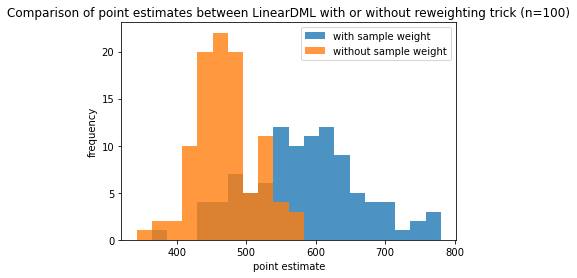

In [20]:
ranges=(min(point_estimate_with_weight+point_estimate_without_weight),
        max(point_estimate_with_weight+point_estimate_without_weight))
plt.hist(point_estimate_with_weight,label="with sample weight",bins=20,range=ranges,alpha=0.8)
plt.hist(point_estimate_without_weight,label="without sample weight",bins=20,range=ranges,alpha=0.8)
plt.legend()
plt.title("Comparison of point estimates between LinearDML with or without reweighting trick (n=100)")
plt.xlabel("point estimate")
plt.ylabel("frequency")

Text(0, 0.5, 'frequency')

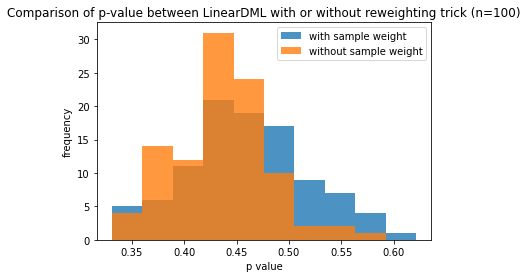

In [21]:
ranges=(min(p_value_with_weight+p_value_without_weight),max(p_value_with_weight+p_value_without_weight))
plt.hist(p_value_with_weight,label="with sample weight",range=ranges,alpha=0.8)
plt.hist(p_value_without_weight,label="without sample weight",range=ranges,alpha=0.8)
plt.legend()
plt.title("Comparison of p-value between LinearDML with or without reweighting trick (n=100)")
plt.xlabel("p value")
plt.ylabel("frequency")

Overall, reweighting the sample substantially improves the ability of the DML model to approximate the experimental average treatment effect using observational data. Recall the benchmark ATE for men is around 817. The average ATE estimated by the unweighted DML model is 471 , while the average ATE from the weighted model is 584. However, adding sample weights increases the variance of the estimate. As shown in the second plot, the estimated treatment effects from the weighted model are somewhat less likely to be significantly different from zero.

# Heterogeneous Treatment Effect with EconML <a id="hte"></a>
Finally, we want to learn whether we could get heterogeneous treatment effect insight using EconML, which could better tell us what kind of people are more or less responsive to this training program. We will start with using the unbiased experimental dataset, and then we are also interested to learn whether the observational dataset could recover the same findings from the 
experiment.

We train a `CausalForestDML` to learn non-parametric heterogeneous treatment effect by fitting a Casual Forest as the final stage model. EconML also supports interpretability tools such as `SingleTreeCateInterpreter` to further segment the users with different responsiveness to the treatment.

## Experimental Data

In [22]:
# experimental data male
X = None
W = df[econml_controls_male].values
# scale W
cols_to_scale=6
scaler = StandardScaler()
W = np.hstack([scaler.fit_transform(W[:, :cols_to_scale]).astype(np.float32), W[:, cols_to_scale:]])
T = df["treated"]
y = df[outcome_name_male]

In [23]:
model_y=first_stage_reg(W, y)
model_t=first_stage_clf(W, T)

In [24]:
est=CausalForestDML(model_y=model_y,model_t=model_t,discrete_treatment=True, mc_iters=5,cv=5)
est.fit(y,T,X=W,W=None)

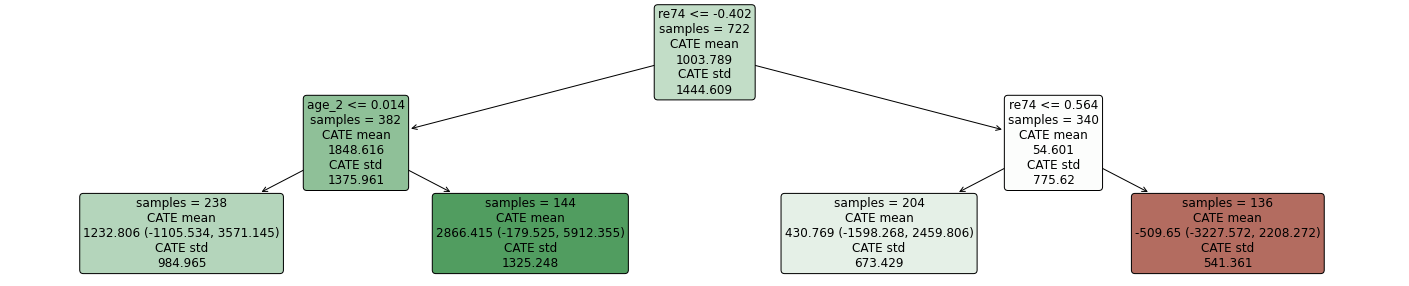

In [25]:
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=2, min_samples_leaf=10)
# We interpret the CATE models behavior on the distribution of heterogeneity features
intrp.interpret(est, W)
# plot
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=econml_controls_male, fontsize=12)
plt.show()

## Observational Control - CPS3

In [26]:
X = None
W = df_cps[econml_controls_male].values
# scale W
cols_to_scale=6
scaler = StandardScaler()
W = np.hstack([scaler.fit_transform(W[:, :cols_to_scale]).astype(np.float32), W[:, cols_to_scale:]])
T = df_cps["treated"]
y = df_cps[outcome_name_male]

In [27]:
model_y=first_stage_reg(W, y)
model_t=first_stage_clf(W, T)

In [28]:
est=CausalForestDML(model_y=model_y,model_t=model_t,discrete_treatment=True, mc_iters=5,cv=5)
est.fit(y,T,X=W,W=None)

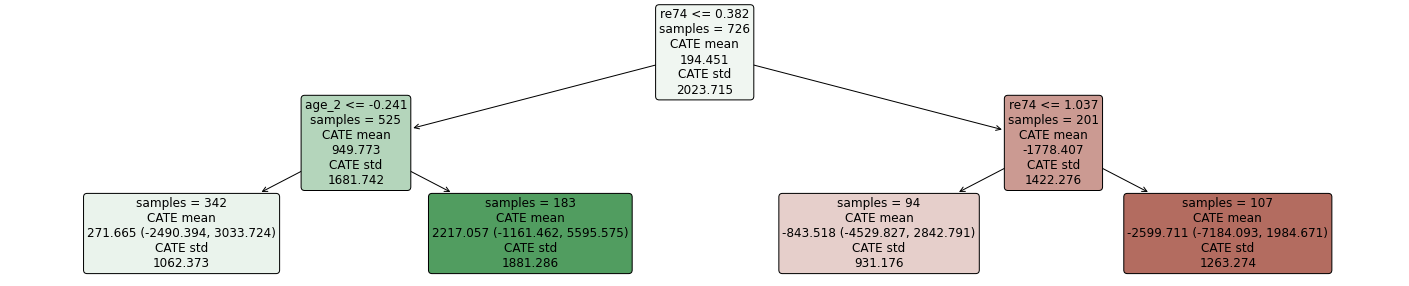

In [29]:
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=2, min_samples_leaf=10)
# We interpret the CATE models behavior on the distribution of heterogeneity features
intrp.interpret(est, W)
# plot
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=econml_controls_male, fontsize=12)
plt.show()

From the experimental tree plot we see this training program has higher positive effects for older workers with lower income before the training. Workers with relatively higher income in the pre-period experience a small and imprecise effect of training. While the exact splits are somewhat different in the observational sample, the main message is the same: the training is most effective for workers with lower pre-period earnings and, within that set, for older workers. 

# Conclusion <a id="conclusion"></a>

In this notebook, we have demonstrated the power of using EconML to:

* Outperform the traditional OLS method on estimating ATE under some settings.
* Substantially improve performance when reweighting samples with analytical confidence intervals.
* Learn treatment effect heterogeneity and recover the same insight from using observational dataset.

To learn more about what EconML can do for you, visit our [website](https://aka.ms/econml), our [GitHub page](https://github.com/py-why/EconML) or our [documentation](https://www.pywhy.org/EconML/). 